<a href="https://colab.research.google.com/github/federicasibilla/GenAI_ecology/blob/main/GAN_ecology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Mount Google Drive to Save results.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Set directory to store results. Directory **AI4Ecology** is located at the root directory of your drive. It is used by all notebooks.

In [2]:
google_drive_dir = "/content/gdrive/My Drive/AI4Ecology/"

In [3]:
import os
dir_name = google_drive_dir+'saved_reals'
if not os.path.exists(dir_name) :
  print(color.RED+"ERROR: "+color.END+" Please run "+color.BOLD+"Pre-processing.ipynb"+" before running this notebook")


# Imports

This notebook uses [Fastai](https://www.fast.ai/), latest version 2.3.0 existing, allows to run smoothly the full notebook.

In [4]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 0px !important;}</style>"))

from time import time

import os
import glob
import shutil

import numpy as np
import itertools as it
import pandas as pd
from tqdm.notebook import tqdm

!pip install fastai --upgrade --quiet
import fastai
from fastai.vision.all import *
from fastai.vision.gan import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="fastai.callback.core")
warnings.filterwarnings("ignore", category=UserWarning, module="fastprogress.fastprogress")

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Notebook Output

This notebook runs a Generative Adversarial Network (GAN) and saving files including *fake* patches which are the output of the training of GAN. These patches could be analysed in a following notebook (*Analyse*) but to allow a better stats a larger simulation is analyzed.

# Processing

Define variables *n_vars* (species to use) and *incl_soil* (if soil is included in the training). Variables need to be consistent among notebooks.

In [5]:
# set the number of plant species or other similar variables to consider
n_vars=8
# set boolean to include soil type (whether gypsum or not) to be considered as another variable treated as a plant species
incl_soil = True
# (this could be generalized to location i.e. ravine/not, north_face/not, etc... alongside the present of a plant

# Train the GAN and generate fake patches

Generative Adversarial Networks (GANs) were first [introduced in 2014](https://arxiv.org/abs/1406.2661). Since then we have seen significant development in GANs. In short, GANs are networks which can learn and mimic distributions (images, speech, music, text, etc). They have great potential for generating fake information which is very similar to the real ones.

To understand a GAN, one needs to understand differences between supervised and unsupervised, and generative models.

 * *Supervised learning*: it requires a labeled training data with input samples X and labels y. The network learns a function that maps the input values to the output values. This function is used to give predictions for new samples which have never been used for training. Using supervised learning we can predict the class labels (y). This task of predicting the class labels is called classification (*discriminative* modeling).

* *Unsupervised learning*: it does not require labeled data for training. The network finds a pattern in the input samples. These patterns charactize the inputs examples and can be used to generate new examples of similar types (in this case they are also called *generative* models).

GANs are Generative and *Adversarial* Networks, this adds a particular to the architecture. GANs are composed of a *Generator* and *Discriminator* that compete with each other. *Generator* tries to create samples as close as possible to the real ones, while the *Discriminator* gets trained to be good at distinguishing between **real** and **fake** samples.

We have a game like scenario. The aim of a GAN is to get both components as good as possible, this will give a fake (generated) samples which will be close to the real ones.



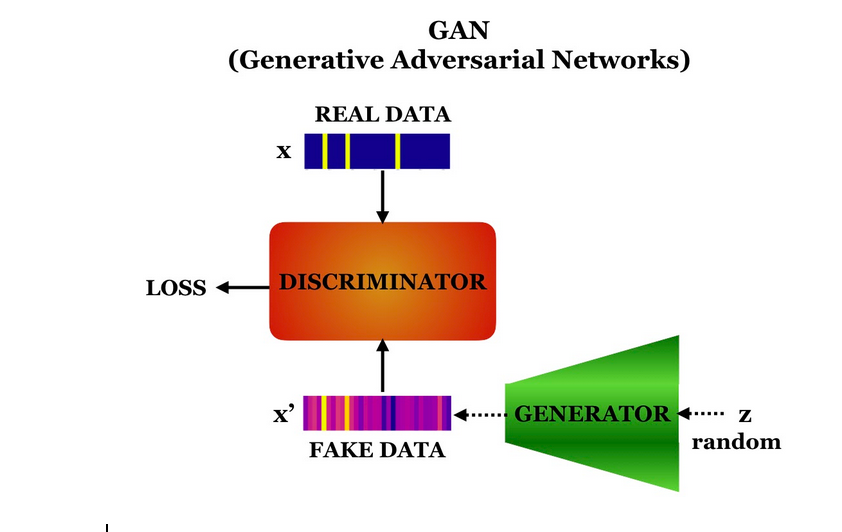

## Create images for GAN

Create images to feed the GAN training. Images will represent presence or abscence of each of the selected species in the patch.

In [6]:
#n our GAN is defined to handle RGB images colors, although we will set all three color values equal
n_colors=3

# our GAN is set to handle square images, but we will simply repeat a line of entries multiple times
n_tile=n_vars

dir_name = google_drive_dir+'saved_reals'
if os.path.exists(dir_name):
  file_name =os.path.join(dir_name,'X__n_vars='+str(n_vars)+'__incl_soil='+str(incl_soil)+'.parquet.gzip')
  X=pd.read_parquet(file_name)
  n_patches = X.shape[0]
  var_names = X.columns.tolist()

In [7]:
# transform the data into a 4D array of n_patches * n_vars * n_tile * n_colors
X_array=np.array(X)
X_4d=np.tile(X_array,(n_tile,1,1))
X_4d=X_4d.transpose(1,2,0)
if n_colors==3:
    X_4d=X_4d[:,np.newaxis].transpose(0,2,3,1)
    X_4d=X_4d*[1,1,1]

X_4d.shape

(2581, 8, 8, 3)

Save images in directories

In [8]:
dir_name = google_drive_dir+'images_for_GAN_training'
try:
    shutil.rmtree(dir_name)
except OSError as e:
  pass

print(f'Creating directories ...')
os.mkdir(dir_name)

dir_name=os.path.join(dir_name,'real_patches__n_vars='+str(n_vars))
IMAGE_PATH= dir_name

if not os.path.exists(dir_name):
      os.mkdir(dir_name)

n_patches = X_4d.shape[0]

print(f'... saving Images ...')
for j in range(n_patches):
    array = X_4d[j,:,:,:]
    array = (array * 255).astype(np.uint8)

    Image.fromarray(array).convert('L').save(os.path.join(dir_name,str(j)+'.png'))

print('... a total of {} images saved at directory {}'.format(n_patches,dir_name))

Creating directories ...
... saving Images ...
... a total of 2581 images saved at directory /content/gdrive/My Drive/AI4Ecology/images_for_GAN_training/real_patches__n_vars=8


Example of representation of some random patches. Yellow bands represent species present in the patch.

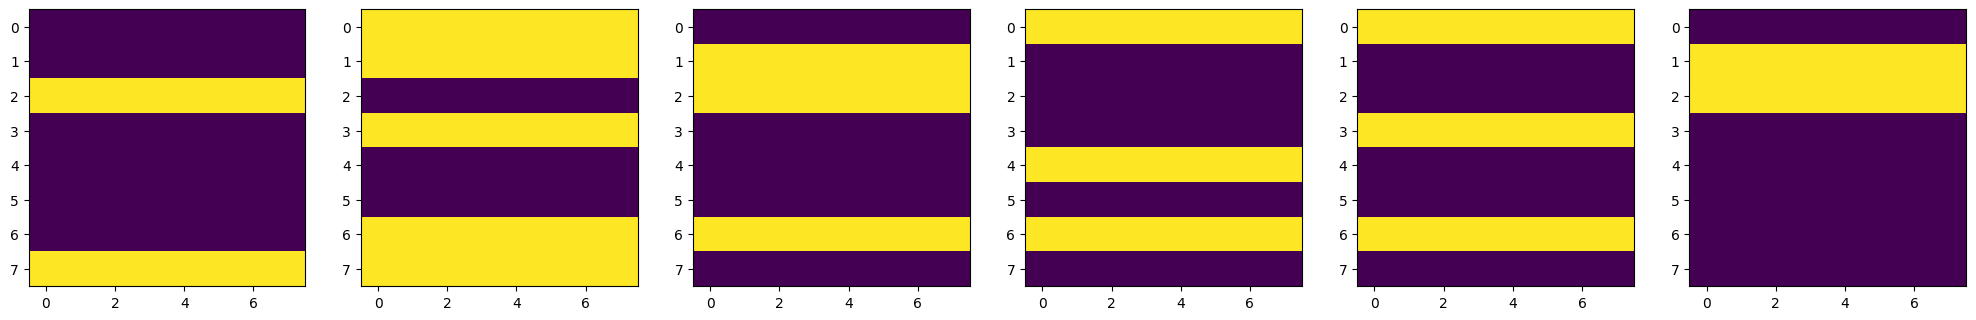

<Figure size 640x480 with 0 Axes>

In [9]:
from PIL import Image

fig, ax = plt.subplots(1, 6, figsize=(25,100))

for x in range(0,6) :
  im = Image.open(os.path.join(dir_name,str(random.randint(0,X_4d.shape[0]))+'.png'))
  ax[x].imshow(im)

plt.show()
plt.tight_layout()

Load all created images in a Datablock for later use.

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


Total images in data 2581.


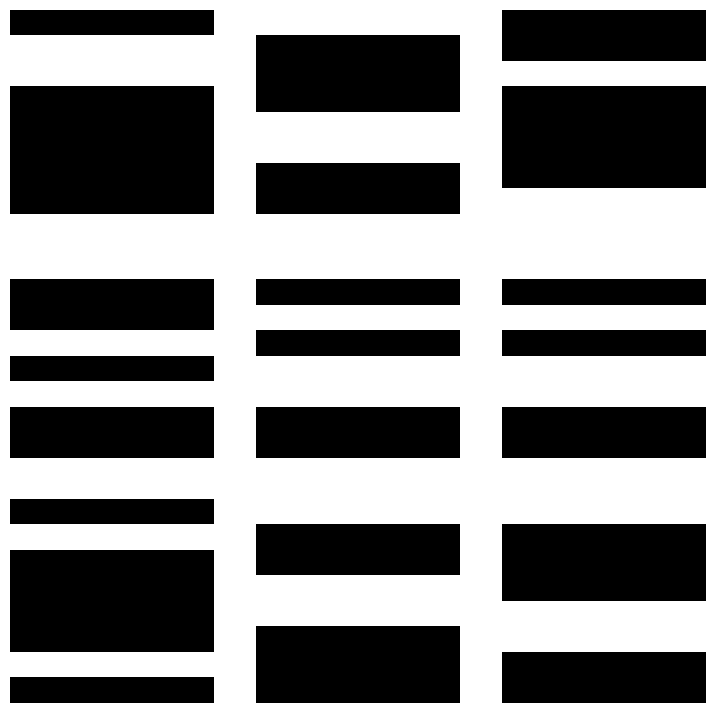

In [10]:
BATCH_SIZE = 64
IMAGE_SIZE = n_vars
noise_sz= 6
def generate_noise(fn, noise_sz=noise_sz): return cast(torch.randn(noise_sz), InvisibleTensor)

dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   item_tfms = Resize(IMAGE_SIZE),
                   splitter = IndexSplitter([]))

dls = dblock.dataloaders(IMAGE_PATH, bs=BATCH_SIZE)
dls.show_batch()
onebatch = dls.one_batch()
print('Total images in data {}.'.format(len(dls.train_ds)))

Come è fatto un batch

In [11]:
# Stampa le dimensioni del batch di input
print("Dimensioni del batch di input:", type(onebatch))

Dimensioni del batch di input: <class 'tuple'>


## Train GAN

Define variables for training, the more epochs and fakes more time will take to run but better will be your output. In the GIT there is an already created output to run the statistical analysis which contain large statistics. Here numbers will be set to be able to run the notebook in around 1 hour in Google Collab.

With 10 epochs and 1000 fakes it will take about 2 minutes per repeat

In [12]:
n_epochs= 10 # For large stats try 3000
n_repeats = 5

n_fakes = 1000 # For large stats try 300000

edge_fraction = .3
midtone = .5
threshold = .5

Training a Generative Adversarial Network involves training both a *Generator* and a *Discriminator* (or *Critic*). Using [Fastai](https://www.fast.ai/) one can simply do:

```
generator = basic_generator(in_size=ins, n_channels=nc, n_extra_layers=nl)
critic    = basic_critic   (in_size=ins, n_channels=nc, n_extra_layers=nl)
learn = GANLearner.wgan(data, generator, critic, opt_func = opt_func=RMSProp)
learn.fit(30,2e-4)
```


 Starting Training repeat 0 will do 10 epochs


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)



 ... done with training found a Generator Loss == 0.0350

 ... saving model GAN__noise_sz=6__n_vars=8__incl_soil=True__n_epochs=10__model_timestamp=2024-01-18_17-28-09__gen_loss=0.035021983087062836

Generating 1000 fake patches



A total of 1000 fakes saved to Drive


 Starting Training repeat 1 will do 10 epochs


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)



 ... done with training found a Generator Loss == 0.0331

 ... saving model GAN__noise_sz=6__n_vars=8__incl_soil=True__n_epochs=10__model_timestamp=2024-01-18_17-30-47__gen_loss=0.033064357936382294

Generating 1000 fake patches



A total of 1000 fakes saved to Drive


 Starting Training repeat 2 will do 10 epochs


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)



 ... done with training found a Generator Loss == 0.0387

 ... saving model GAN__noise_sz=6__n_vars=8__incl_soil=True__n_epochs=10__model_timestamp=2024-01-18_17-33-19__gen_loss=0.038732003420591354

Generating 1000 fake patches



A total of 1000 fakes saved to Drive


 Starting Training repeat 3 will do 10 epochs


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)



 ... done with training found a Generator Loss == 0.0396

 ... saving model GAN__noise_sz=6__n_vars=8__incl_soil=True__n_epochs=10__model_timestamp=2024-01-18_17-35-52__gen_loss=0.03963685408234596

Generating 1000 fake patches



A total of 1000 fakes saved to Drive


 Starting Training repeat 4 will do 10 epochs


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)



 ... done with training found a Generator Loss == 0.0296

 ... saving model GAN__noise_sz=6__n_vars=8__incl_soil=True__n_epochs=10__model_timestamp=2024-01-18_17-38-26__gen_loss=0.029625728726387024

Generating 1000 fake patches



A total of 1000 fakes saved to Drive



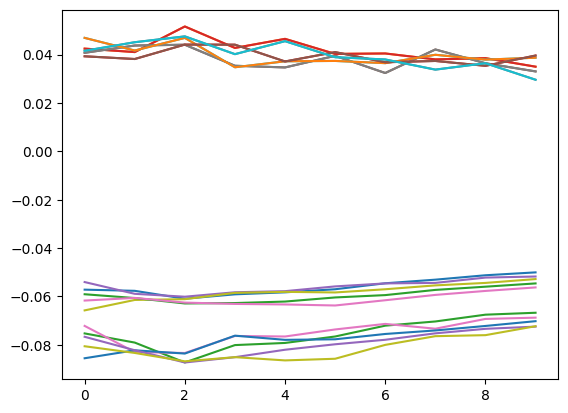

In [14]:
# Set to True to show metrics
show_plots = False

#training loop
for j in range(n_repeats):
    n_total_epochs = 0

    print("\n Starting Training"+color.RED+" repeat "+str(j)+color.END+" will do "+color.RED+str(n_epochs)+color.END+" epochs")

    # Generator Definition (https://docs.fast.ai/vision.gan.html#basic_generator)
    generator = basic_generator(IMAGE_SIZE, in_sz=noise_sz, n_channels=n_colors, n_extra_layers=1)

    # Critic Definition (https://docs.fast.ai/vision.gan.html#basic_critic)
    critic = basic_critic(IMAGE_SIZE, n_channels=n_colors, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))

    # Learner (https://docs.fast.ai/vision.gan.html#GANLearner)
    learn = GANLearner.wgan(dls, generator=generator, critic=critic, opt_func=RMSProp)
    learn.recorder.train_metrics = True
    learn.recorder.valid_metrics = False
    learn.model_dir = google_drive_dir+'models'

    with learn.no_logging():
        learn.fit(n_epochs, 2e-4, wd=0.)
    n_total_epochs += len(L(learn.recorder.values))

    plt.plot(L(learn.recorder.values))
    if show_plots : plt.show()

    gen_loss = learn.recorder.values[-1][1]
    print("\n ... done with training found a "+color.BLUE+"Generator Loss == {:.4f}".format(gen_loss)+color.END)

    plt.plot(L(learn.recorder.values).itemgot(1))
    if show_plots : plt.show()


    # Saving the model
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_name='GAN__noise_sz='+str(noise_sz)+'__n_vars='+str(n_vars)+'__incl_soil='+str(incl_soil)+'__n_epochs='+str(n_total_epochs)+'__model_timestamp='+timestamp+'__gen_loss='+str(gen_loss)

    print('\n ... saving model {}'.format(model_name))
    learn.save(model_name)

    print("\nGenerating "+color.BLUE+str(n_fakes)+color.END+" fake patches")

    # Fake patches Generation
    tst_dl = learn.dls.test_dl(cast(torch.randn(n_fakes,noise_sz), InvisibleTensor))
    preds = learn.get_preds(dl=tst_dl,with_decoded=True)
    fakes_4d=preds[0].numpy().transpose(0,2,3,1)

    # Define edges of tile that can be removed: we expect n_var constant lines in the images, but there may be boundary effects
    edge = int(np.floor(edge_fraction * n_tile))
    begin_select = edge
    end_se1ect = n_tile - edge

    # Average over the remaining length and over the three colors
    cont_2d=fakes_4d.mean(3)[:,:,begin_select:end_se1ect].mean(2)

    # Apply a binary threshold to get a yes/no answer to the question of whether this species is present or not
    fakes_2d=midtone*(1+np.sign(cont_2d-threshold))
    fakes_df = pd.DataFrame(fakes_2d)


    # Save fake patches
    fakes_df.columns = var_names
    dir_name=google_drive_dir+'saved_fakes'
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

    file_name=os.path.join(dir_name,'GAN_fakes__'+model_name+'__n_fakes='+str(n_fakes)+'.parquet.gzip')

    fakes_df.to_parquet(file_name,compression='gzip')
    print(color.BOLD+'\nA total of {} fakes saved to Drive'.format(n_fakes)+color.END+"\n")

# Pre-process results

Preprocess results for posterior interpretation. Tools to produce plots and tables that can be studied are shown in another notebook, also included in GIT.

In [18]:
# choose confidence interval
n_sigmas = 2

var_indices = range(n_vars)

def N(X,i,j,k,l):
# this should probably be parallelized
    return len(X[(X.iloc[:,i] != 0) & (X.iloc[:,j] != 0) & (X.iloc[:,k] != 0) & (X.iloc[:,l] != 0)]) #this is faster but works only for binary 0/1 entries

For later analysis we will compute probabilities and saved them to file:

* Abundance of A when another species B is already present in the patch, P(A|B)

$P(A \mid B) = \frac{P(A \cap B)}{P(B)}$

* Abundance of species A when two other species (B and C) are already present in the patch, P(A|BC)

$P(A \mid BC) = \frac{P(A \cap BC)}{P(BC)}$



In [19]:
var_indices = range(int(n_vars))
def compute_stats(df):
    temp = pd.DataFrame()

    for sample_id in tqdm(df['sample_id'].unique().tolist(),desc="Computing probabilities :"):
        sample = df[df['sample_id']==sample_id]
        sample = sample.drop('sample_id',axis=1)

        n_patches = sample.shape[0]
        joint = np.array([[[[N(sample,i,j,k,l) for l in var_indices] for k in var_indices] for j in var_indices] for i in var_indices])/n_patches


        for i, j, k, l in it.permutations(var_indices, r=4):

            # Compute probabilites
            temp=temp.append(pd.DataFrame([var_names[i],var_names[j],var_names[k]
                                           ,var_names[l]
                                           ,sample_id

                                           ,joint[i,i,i,i] # p(a)
                                           ,joint[j,j,j,j] # p(b)
                                           ,joint[k,k,k,k] # p(c)
                                           ,joint[l,l,l,l] # p(d)

                                           ,joint[i,j,j,j] # p(a,b)
                                           ,joint[i,j,k,k] # p(a,b,c)
                                           ,joint[i,j,k,l] # p(a,b,c,d)

                                           ,joint[i,j,j,j]/joint[j,j,j,j] # p(a|b)
                                           ,joint[i,j,k,k]/joint[j,k,k,k] # p(a|b,c)
                                           ,joint[i,j,k,l]/joint[j,k,l,l] # p(a|b,c,d)
                                          ]).T,ignore_index=True)

    # Column definitions
    temp.columns = ['a','b','c'
                   ,'d'
                    ,'sample_id'

                    ,'p(a)'
                    ,'p(b)'
                    ,'p(c)'
                    ,'p(d)'

                    ,'p(a,b)'
                    ,'p(a,b,c)'
                    ,'p(a,b,c,d)'

                    ,'p(a|b)'
                    ,'p(a|b,c)'
                    ,'p(a|b,c,d)'
                   ]
    temp=temp.set_index(['a','b','c','d'])

    temp['p(a|b)-p(a)'] = temp['p(a|b)'] - temp['p(a)']
    temp['p(a|b,c)-p(a|b)'] = temp['p(a|b,c)'] - temp['p(a|b)']
    temp['p(a|b,c,d)-p(a|b,c)'] = temp['p(a|b,c,d)'] - temp['p(a|b,c)']

    return temp.convert_dtypes()

## Read in fake patches

Check what has been produced so far.

In [20]:
# Choose data to analyze (defined above too)
n_vars = 8
incl_soil = True
noise_sz = 6

In [21]:
pattern=google_drive_dir+'saved_fakes/GAN_fakes__GAN__noise_sz='+str(noise_sz)+'__n_vars='+str(n_vars)+'__incl_soil='+str(incl_soil)+'*000*.parquet.gzip'
list_fakes=sorted(glob.glob(pattern), key=os.path.getmtime)
n_fake_samples = len(list_fakes)
print(" A total of "+str(n_fake_samples)+" files with fakes")

 A total of 10 files with fakes


In [22]:
#sort the columns according to abundance of plant species
if incl_soil == False:
    offset = 0
if incl_soil == True:
    offset = 1

fakes=pd.DataFrame()
for i in range(len(list_fakes)):
    fakes_df = pd.read_parquet(list_fakes[i])
    #remove patches with fewer than two plant species
    fakes_df = fakes_df[fakes_df.iloc[:,offset:].sum(axis=1)>1]
    temp = pd.DataFrame(fakes_df)
    temp.insert(0,'sample_id',i)
    fakes = fakes.append(temp)

fakes

<ipython-input-22-8f2aa8fdb3a9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fakes = fakes.append(temp)
<ipython-input-22-8f2aa8fdb3a9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fakes = fakes.append(temp)
<ipython-input-22-8f2aa8fdb3a9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fakes = fakes.append(temp)
<ipython-input-22-8f2aa8fdb3a9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fakes = fakes.append(temp)
<ipython-input-22-8f2aa8fdb3a9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fakes = fakes.append(temp)
<ipython-i

,sample_id,Gypsum,Fumana_thymifolia,Stipa_tenacissima,Helianthemum_syriacum,Helianthemum_squamatum,Teucrium_libanitis,Brachypodium_retusum,Fumana_ericoides
0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
995,9,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
996,9,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
997,9,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
998,9,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


Summary of GAN processing

In [23]:
dir_name = google_drive_dir+'saved_fakes'

pattern =os.path.join(dir_name,'GAN_fakes__GAN__noise_sz=*__n_vars=*__incl_soil=*__n_epochs=*__n_fakes=*.parquet.gzip')

fakes_list = glob.glob(pattern)

df = pd.DataFrame()
for file_name in fakes_list:
    n_vars = file_name.split('n_vars=')[-1].split('__')[0]
    incl_soil = file_name.split('incl_soil=')[-1].split('__')[0]
    noise_sz = file_name.split('noise_sz=')[-1].split('__')[0]
    n_epochs = file_name.split('n_epochs=')[-1].split('__')[0]
    temp = pd.DataFrame([eval(n_vars),eval(incl_soil),eval(noise_sz),eval(n_epochs),file_name]).T
    df=df.append(temp,ignore_index=True)


df.columns=['n_vars','include soil','noise_sz','n_epochs','file name']
count_GAN_runs = df.groupby(['n_vars','include soil','noise_sz','n_epochs']).count()
count_GAN_runs.columns = ['number of GAN runs recorded']
count_GAN_runs

<ipython-input-23-f255d086ebb9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp,ignore_index=True)


,,,,number of GAN runs recorded
n_vars,include soil,noise_sz,n_epochs,
8,True,6,10,10


## Boostrapping on the fake patches

Compute probabilities for fake patches

In [24]:
# can take several minutes for a few populations of patches 8 variables up to quadratic interactions
dir_name = google_drive_dir+'saved_stats'
if not os.path.exists(dir_name):
        os.mkdir(dir_name)

stats_fakes = compute_stats(fakes)
file_name =os.path.join(dir_name,'stats_fakes__GAN__n_vars='+str(n_vars)+'__incl_soil='+str(incl_soil)+'__noise_sz='+str(noise_sz)+'__n_epochs='+str(n_epochs)+'.parquet.gzip')
stats_fakes.to_parquet(file_name,compression='gzip')

Computing probabilities ::   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-19-2d065a7ea317>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp=temp.append(pd.DataFrame([var_names[i],var_names[j],var_names[k]
<ipython-input-19-2d065a7ea317>:31: RuntimeWarning: invalid value encountered in double_scalars
  ,joint[i,j,k,l]/joint[j,k,l,l] # p(a|b,c,d)
<ipython-input-19-2d065a7ea317>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp=temp.append(pd.DataFrame([var_names[i],var_names[j],var_names[k]
<ipython-input-19-2d065a7ea317>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp=temp.append(pd.DataFrame([var_names[i],var_names[j],var_names[k]
<ipython-input-19-2d065a7ea317>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

## Boostrapping on the real patches

Compute probabilites for real patches

In [25]:
n_resamples=30
reals=pd.DataFrame()
for i in range(n_resamples):
    temp=X.sample(frac=1, replace=True)
    temp.insert(0,'sample_id',i)
    reals=reals.append(temp).reset_index(drop=True)
reals

<ipython-input-25-53b3c4b00742>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reals=reals.append(temp).reset_index(drop=True)
<ipython-input-25-53b3c4b00742>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reals=reals.append(temp).reset_index(drop=True)
<ipython-input-25-53b3c4b00742>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reals=reals.append(temp).reset_index(drop=True)
<ipython-input-25-53b3c4b00742>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reals=reals.append(temp).reset_index(drop=True)
<ipython-input-25-53b3c4b00742>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

species,sample_id,Gypsum,Fumana_thymifolia,Stipa_tenacissima,Helianthemum_syriacum,Helianthemum_squamatum,Teucrium_libanitis,Brachypodium_retusum,Fumana_ericoides
0,0,1,0,0,1,0,1,0,0
1,0,1,0,0,0,1,1,0,0
2,0,0,1,1,0,0,0,1,1
3,0,0,1,0,0,0,0,1,0
4,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
77425,29,0,1,1,0,0,0,0,0
77426,29,0,1,0,0,0,0,1,0
77427,29,0,1,1,0,0,0,1,1
77428,29,0,1,1,0,0,0,1,0


In [26]:
# can take several minutes for a few bootstraps of 8 variables up to quadratic interactions
dir_name = google_drive_dir+'saved_stats'
if not os.path.exists(dir_name):
        os.mkdir(dir_name)

stats_reals = compute_stats(reals)
file_name =os.path.join(dir_name,'stats_reals__n_vars='+str(n_vars)+'__incl_soil='+str(incl_soil)+'.parquet.gzip')
stats_reals.to_parquet(file_name,compression='gzip')

Computing probabilities ::   0%|          | 0/30 [00:00<?, ?it/s]

<ipython-input-19-2d065a7ea317>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp=temp.append(pd.DataFrame([var_names[i],var_names[j],var_names[k]
<ipython-input-19-2d065a7ea317>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp=temp.append(pd.DataFrame([var_names[i],var_names[j],var_names[k]
<ipython-input-19-2d065a7ea317>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp=temp.append(pd.DataFrame([var_names[i],var_names[j],var_names[k]
<ipython-input-19-2d065a7ea317>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp=temp.append(pd.DataFrame([var_names[i],var_names[j],var_names[k]
<ipython-input-19-2d065a7ea317>:16: 

# Summary of Outputs produced

Different directories have been created at this point:

* **saved_reals** : Real data patches (real data)
* **images_for_GAN_training** : image representation of the patches measured (real data)
* **saved_fakes** : includes output of running GAN (simulated data)
* **models**      : model output of the training
* **saved_stats** : Statistical analysis of the real and fake patches

Already existing in GIT **saved_stats** directory will be used in the additional notebook


In [23]:
!ls -ltr "$google_drive_dir"

total 20
drwx------ 2 root root 4096 Jan 17 08:04 saved_reals
drwx------ 3 root root 4096 Jan 17 08:17 images_for_GAN_training
drwx------ 2 root root 4096 Jan 17 09:12 saved_fakes
drwx------ 2 root root 4096 Jan 17 09:12 models
drwx------ 2 root root 4096 Jan 17 09:38 saved_stats


In [27]:
print(generator)

Sequential(
  (0): AddChannels()
  (1): ConvLayer(
    (0): ConvTranspose2d(6, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): Tanh()
)
